In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import data, io, draw, color, transform
from skimage.io import imshow
import imageio
import skimage
from sklearn.cluster import KMeans
import random
import dictances
from scipy.spatial import distance
from dictances import bhattacharyya, bhattacharyya_coefficient

In [2]:
def get_sift(filename):
    
    img = cv2.imread(filename)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    key_point, descriptor = cv2.SIFT_create().detectAndCompute(img_gray, None)

    return img_gray, key_point, descriptor

In [3]:
def Kullback_Leibler_Divergence(a,b):

    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Data Preprocess

In [4]:
path_prex = 'C:/Users/lenovo/Downloads/101_ObjectCategories/'

"""
5 categories
"""
picked_category = ['wheelchair', 'helicopter', 'flamingo_head', 'menorah', 'dolphin']

"""
20 categories
"""
# picked_category = ['airplanes', 'bonsai', 'brain', 'watch', 'buddha', 'butterfly', 'trilobite', 'sunflower', 'car_side', 'starfish', 'chandelier', 'scorpion', 'revolver', 'motorbikes', 'ewer', 'menorah', 'Faces', 'leopards', 'laptop', 'ketch']

train_path_list = []
test_path_list = []

"""
train/test split
"""

image_per_cate = 20

for category in picked_category:
    
    image_total_number = 0
    
    for filename in os.listdir(path_prex + category):
        
        image_total_number+=1
        
        img = path_prex + category + '/' + filename

        if image_total_number<=image_per_cate:
            train_path_list.append(img)
        elif (image_total_number>image_per_cate)and(image_total_number<=2*image_per_cate):
            test_path_list.append(img)
        else:
            break

# Codebook Generation

In [5]:
all_des_list_train = []
all_des_matrix_train=np.zeros((1,128))

for img in train_path_list:
    img_gray, key_point, descriptor = get_sift(img)
    all_des_list_train.append(descriptor)
    all_des_matrix_train = np.row_stack((all_des_matrix_train, descriptor))

all_des_matrix_train = all_des_matrix_train[1:,:]

In [6]:
k = 200
kmeans = KMeans(n_clusters=k, random_state=0).fit(all_des_matrix_train) 

In [7]:
"""
get train set BoW
"""

feature_train = []

for i in range(len(train_path_list)):
    bow_img = kmeans.predict(np.array(all_des_list_train[i], dtype=float))
    img_feature_vector = np.histogram(bow_img, bins=np.arange(0, k+1))[0]
    feature_train.append(img_feature_vector)

# Index

In [8]:
all_des_list_test = []
all_des_matrix_test=np.zeros((1,128))


for img in test_path_list:
    img_gray, key_point, descriptor = get_sift(img)
    all_des_list_test.append(descriptor)
    all_des_matrix_test = np.row_stack((all_des_matrix_test, descriptor))

all_des_matrix_test = all_des_matrix_test[1:,:]

In [9]:
"""
get test set BoW
"""

feature_test = []

for i in range(len(test_path_list)):
    bow_img = kmeans.predict(np.array(all_des_list_test[i], dtype=float))
    img_feature_vector = np.histogram(bow_img, bins=np.arange(0, k+1))[0]
    feature_test.append(img_feature_vector)

In [10]:
"""
get table
"""

table = {}

train_total_num = len(train_path_list)
test_total_num = len(test_path_list)

for i in range(len(train_path_list)+len(test_path_list)):
    if i<train_total_num:
        img_category = train_path_list[i][len(path_prex):].split('/')[0]
        table[i] = [train_path_list[i], img_category, 'train', feature_train[i]]
    elif (i>=train_total_num)and(i<(train_total_num + test_total_num)):
        img_category = test_path_list[i-train_total_num][len(path_prex):].split('/')[0]
        table[i] = [test_path_list[i-train_total_num], img_category, 'test', feature_test[i-train_total_num]]
    else:
        break

In [11]:
df = pd.DataFrame(table)

In [12]:
df.T[0][0]

'C:/Users/lenovo/Downloads/101_ObjectCategories/wheelchair/image_0001.jpg'

In [13]:
df.T

,0,1,2,3
0,C:/Users/lenovo/Downloads/101_ObjectCategories...,wheelchair,train,"[1, 5, 4, 2, 1, 3, 4, 7, 2, 7, 2, 7, 1, 3, 2, ..."
1,C:/Users/lenovo/Downloads/101_ObjectCategories...,wheelchair,train,"[1, 4, 4, 9, 1, 5, 3, 9, 1, 1, 2, 1, 2, 7, 1, ..."
2,C:/Users/lenovo/Downloads/101_ObjectCategories...,wheelchair,train,"[5, 4, 15, 3, 2, 3, 3, 0, 3, 7, 7, 3, 3, 0, 0,..."
3,C:/Users/lenovo/Downloads/101_ObjectCategories...,wheelchair,train,"[7, 2, 10, 1, 2, 6, 4, 2, 1, 3, 4, 2, 0, 0, 2,..."
4,C:/Users/lenovo/Downloads/101_ObjectCategories...,wheelchair,train,"[10, 3, 4, 5, 2, 7, 4, 7, 7, 15, 3, 5, 3, 4, 4..."
...,...,...,...,...
195,C:/Users/lenovo/Downloads/101_ObjectCategories...,dolphin,test,"[2, 1, 0, 2, 1, 2, 4, 5, 3, 3, 3, 0, 2, 3, 1, ..."
196,C:/Users/lenovo/Downloads/101_ObjectCategories...,dolphin,test,"[5, 3, 1, 3, 2, 0, 5, 2, 2, 4, 3, 2, 2, 2, 2, ..."
197,C:/Users/lenovo/Downloads/101_ObjectCategories...,dolphin,test,"[2, 0, 0, 3, 0, 3, 5, 3, 3, 2, 8, 0, 1, 1, 2, ..."
198,C:/Users/lenovo/Downloads/101_ObjectCategories...,dolphin,test,"[2, 0, 0, 3, 0, 0, 1, 0, 2, 0, 3, 0, 0, 0, 0, ..."


In [95]:
df.to_csv("data5.csv", index_label="index_label")

# Retrieving

In [12]:
train_df = df.T[df.loc[2] == 'train']
test_df = df.T[df.loc[2] == 'test']
top_num = 3

## retrieval experiment 1
query: train; base: train

In [13]:
result_list = []
all_dist = []

for target_img_feature_vector in train_df[3]:
    
    dist_per_query = []
    
    for search_img_feature_vector in train_df[3]:
        
        if target_img_feature_vector.all!=search_img_feature_vector.all:
        
            vector_dist = distance.euclidean(target_img_feature_vector, search_img_feature_vector)
#             vector_dist = Kullback_Leibler_Divergence(target_img_feature_vector, search_img_feature_vector)

            dist_per_query.append(vector_dist)
    
    dist_per_query = np.array(dist_per_query)
    all_dist.append(dist_per_query)
    result_index = np.argsort(dist_per_query)
    
    result_list.append(result_index)

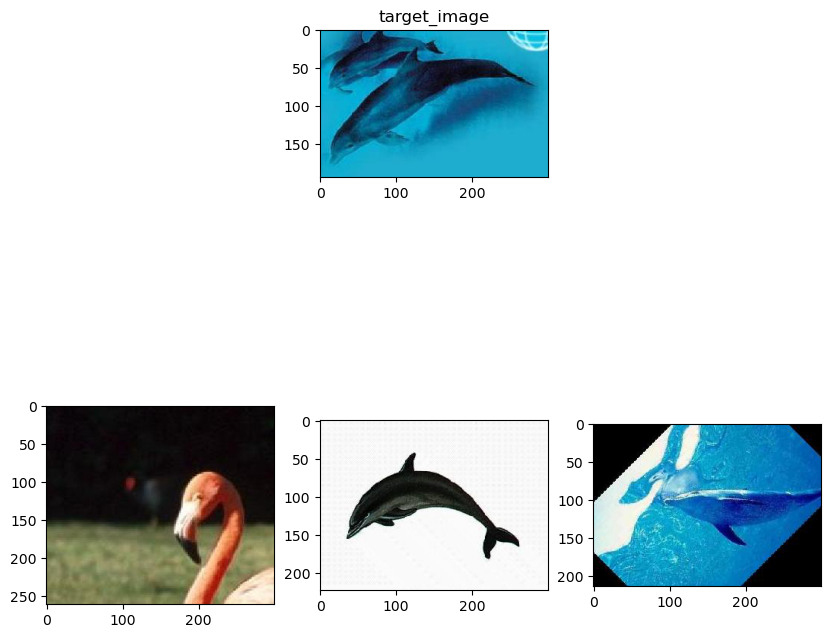

In [14]:
show_which_index = 98

plt.figure(figsize=(10,20))

target_img_path = train_df[0].iloc[show_which_index]

plt.subplot(432),plt.imshow(plt.imread(target_img_path)),plt.title('target_image')

# print(result_list[show_which_index])

for i in range(top_num):
    index = result_list[show_which_index][i]
    path = train_df[0].iloc[index]
    plt.subplot(4,3,i+4),plt.imshow(plt.imread(path))

plt.show()

In [15]:
is_in_top = []
rank = []

for i in range(len(train_df)):
    
    target_category = train_df[1].iloc[i]
    
    for j in range(len(train_df)):
        search_category = train_df[1].iloc[result_list[i][j]]
        if target_category==search_category:
            break
    
    correct_rank = j+1
    rank.append(correct_rank)
    
    if correct_rank<=3:
        is_in_top.append('True')
    else:
        is_in_top.append('False')
        
# print(rank)
# print(is_in_top)

In [16]:
rank_reciprocal = np.reciprocal(np.array(rank), dtype='float32')
mrr = rank_reciprocal.sum() / (len
                               (train_df))
mrr

0.6569417572021484

In [17]:
freq_is_in_top = is_in_top.count('True')
freq_is_in_top / (len(train_df)) * 100

79.0

# retrieval experiment 2
query: test; base: train

In [18]:
"""
retrieval test images
"""

result_list = []

for target_img_feature_vector in test_df[3]:
    
    dist_per_query = []
    
    for search_img_feature_vector in train_df[3]:
        
        if target_img_feature_vector.all!=search_img_feature_vector.all:
        
            vector_dist = distance.euclidean(target_img_feature_vector, search_img_feature_vector)
    #         vector_dist = Kullback_Leibler_Divergence(target_img_feature_vector, search_img_feature_vector)

            dist_per_query.append(vector_dist)
    
    dist_per_query = np.array(dist_per_query)
    result_index = np.argsort(dist_per_query)
    
    result_list.append(result_index)

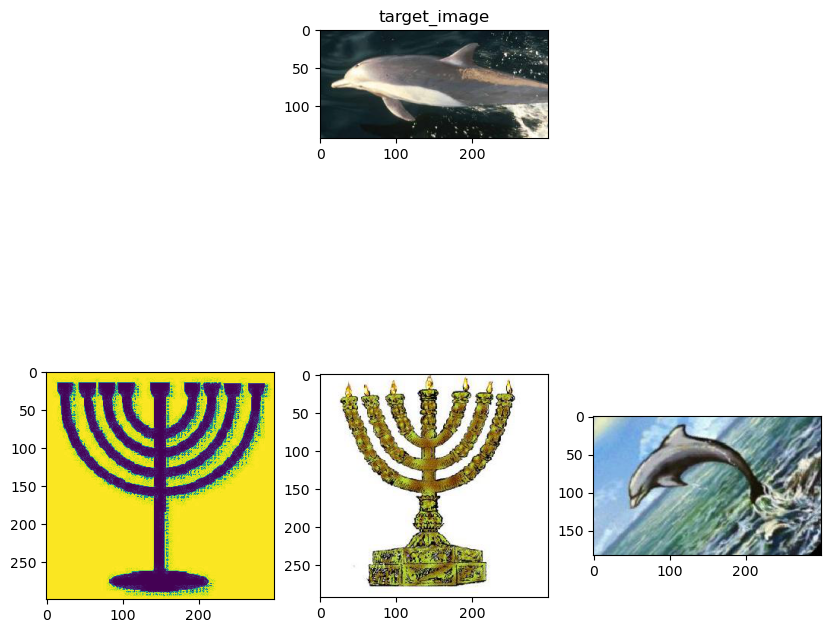

In [19]:
plt.figure(figsize=(10,20))

target_img_path = test_df[0].iloc[show_which_index]

plt.subplot(432),plt.imshow(plt.imread(target_img_path)),plt.title('target_image')

# print(result_list[3])

for i in range(top_num):
    index = np.where(result_list[show_which_index] == i)[0][0]
    path = train_df[0].iloc[index]
    plt.subplot(4,3,i+4),plt.imshow(plt.imread(path))

plt.show()

In [20]:
is_in_top = []
rank = []

for i in range(len(test_df)):
    
    target_category = test_df[1].iloc[i]
    
    for j in range(len(train_df)):
        search_category = train_df[1].iloc[result_list[i][j]]
        if target_category==search_category:
            break
    
    correct_rank = j+1
    rank.append(correct_rank)
    
    if correct_rank<=3:
        is_in_top.append('True')
    else:
        is_in_top.append('False')
        
# print(rank)
# print(is_in_top)

In [21]:
rank_reciprocal = np.reciprocal(np.array(rank), dtype='float32')
mrr = rank_reciprocal.sum() / (len(test_df))
mrr

0.6345774078369141

In [22]:
freq_is_in_top = is_in_top.count('True')
freq_is_in_top / (len(test_df)) * 100

72.0